In [1]:
# !pip install seaborn 1> /dev/null # 1> means redirect stdout

# Import

In [2]:
import pandas as pd
from sklearn.metrics import cohen_kappa_score, classification_report, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, Normalizer
from sklearn.model_selection import train_test_split, cross_validate, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
pd.set_option('display.max_rows', 500)
random_state = 42
data_filepath = './data/'
# data_filepath = '/kaggle/input/child-mind-institute-problematic-internet-use/'

# Data

In [3]:
!du -hs $data_filepath*
train_df = pd.read_csv(data_filepath + 'train.csv')
test_df = pd.read_csv(data_filepath + 'test.csv')
train_df.shape, test_df.shape

6.2G	./data/child-mind-institute-problematic-internet-use.zip
 12K	./data/data_dictionary.csv
4.0K	./data/sample_submission.csv
7.9M	./data/series_test.parquet
6.3G	./data/series_train.parquet
8.0K	./data/test.csv
924K	./data/train.csv


((3960, 82), (20, 59))

In [4]:
train_df.sii.value_counts(dropna=False)

sii
0.0    1594
NaN    1224
1.0     730
2.0     378
3.0      34
Name: count, dtype: int64

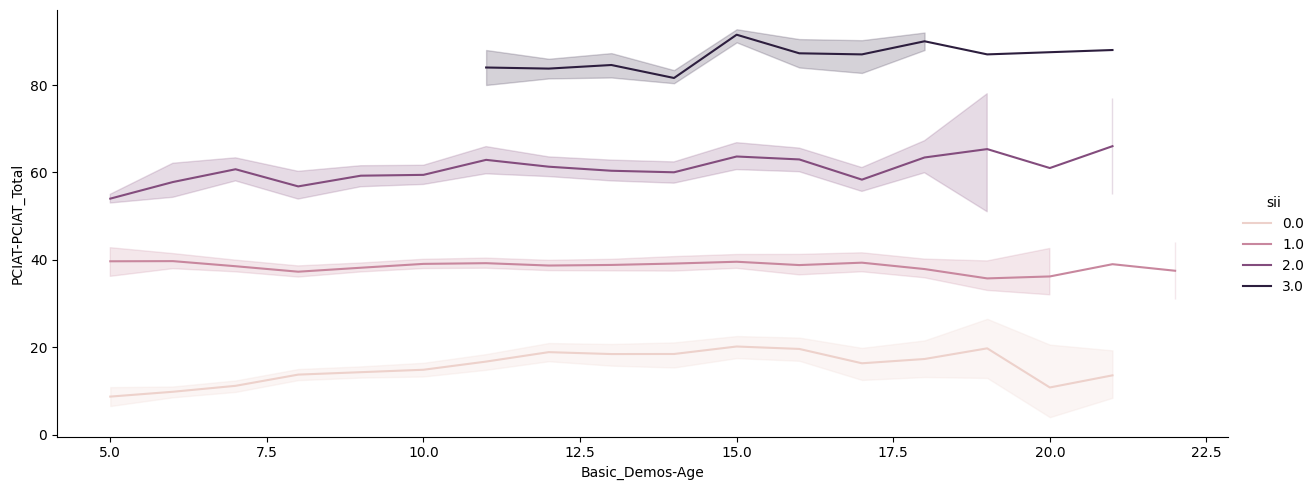

In [5]:
sns.relplot(train_df, x='Basic_Demos-Age', y='PCIAT-PCIAT_Total', hue='sii', kind='line', aspect=2.5)

# Fill missing

In [6]:
cols_to_drop = ['sii', 'id']
X, y = train_df.drop(columns=cols_to_drop), train_df.sii
X.shape, y.shape

((3960, 80), (3960,))

In [7]:
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include='number').columns.tolist()

In [8]:
numeric_transormer = Pipeline(steps=[
    # ('imputer', SimpleImputer(strategy='median')),
    ('imputer', SimpleImputer(strategy='constant', fill_value=-999)),
])  
category_transormer = Pipeline(steps=[
    # ('imputer', SimpleImputer(strategy='most_frequent')),
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OrdinalEncoder()),
])
cols_transformer = ColumnTransformer(transformers=[
    ('numeric', numeric_transormer, num_cols),
    ('category', category_transormer, cat_cols),
])
preproc_df_pipe = Pipeline(steps=[
    ('cols_transformer', cols_transformer),
    ('scaler', StandardScaler()),
    ('nomralize', Normalizer(norm='l2')),
])
preproc_df_pipe

Pipeline(steps=[('cols_transformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=-999,
                                                                                 strategy='constant'))]),
                                                  ['Basic_Demos-Age',
                                                   'Basic_Demos-Sex',
                                                   'CGAS-CGAS_Score',
                                                   'Physical-BMI',
                                                   'Physical-Height',
                                                   'Physical-Weight',
                                                   'Physical-Waist_Circumference',
                                                   'Physical-Diastolic_BP',
                                                   'Physical-HeartRate',
                                                   'Physica...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Basic_Demos-Enroll_Season',
                                                   'CGAS-Season',
                                                   'Physical-Season',
                                                   'Fitness_Endurance-Season',
                                                   'FGC-Season', 'BIA-Season',
                                                   'PAQ_A-Season',
                                                   'PAQ_C-Season',
                                                   'PCIAT-Season', 'SDS-Season',
                                                   'PreInt_EduHx-Season'])])),
                ('scaler', StandardScaler()), ('nomralize', Normalizer())])

In [9]:
X = pd.DataFrame(preproc_df_pipe.fit_transform(X), columns=X.columns)
X

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,...,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,-0.186843,-0.094741,0.094515,0.067773,0.065497,0.055307,-0.066557,-0.210541,-0.212381,-0.210512,...,0.052727,-0.170376,0.075887,-0.170084,-0.211937,0.040662,0.092410,-0.186548,0.136638,-0.167864
1,-0.053014,-0.101886,-0.165683,0.072017,0.071027,0.058083,0.242440,0.078628,0.073169,0.078462,...,0.144760,-0.183225,0.081610,-0.182911,0.034988,0.043728,-0.276677,-0.200617,-0.209282,0.022999
2,-0.013517,0.144549,0.089979,0.061384,0.061992,0.056217,-0.060341,0.063890,0.067390,0.064998,...,-0.174899,-0.154462,-0.258756,-0.154197,0.103375,0.036864,-0.074732,-0.169124,-0.176428,0.019389
3,-0.052671,-0.101227,0.106045,0.072842,0.072914,0.067987,-0.071114,0.073887,0.080263,0.076604,...,-0.206126,0.009607,-0.111937,0.013429,-0.052308,0.043446,0.005331,-0.022345,-0.030968,0.123954
4,0.180523,0.110625,-0.106894,-0.153053,-0.153582,-0.158475,-0.046179,-0.146079,-0.147355,-0.146058,...,-0.020228,0.130688,0.052653,0.135450,0.079114,-0.169173,0.064117,0.100411,0.094803,0.146145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,0.091644,-0.098384,0.100362,0.070228,0.071864,0.066302,-0.069117,0.074829,0.070654,0.071038,...,-0.115306,-0.176927,0.078805,-0.176625,-0.220087,0.042225,0.005181,0.064284,0.055897,-0.174319
3956,-0.012606,-0.080103,-0.130261,0.057755,0.057118,0.052612,0.191817,0.058469,0.059300,0.060832,...,0.113812,-0.068226,0.064163,-0.066590,-0.110293,0.034380,0.004218,0.122362,0.115527,0.098087
3957,0.021172,-0.102984,0.107113,0.075078,0.075373,0.077452,-0.072348,0.080624,0.082227,0.077658,...,-0.120697,0.107260,0.082490,0.112935,0.035365,0.044200,0.005423,0.067290,0.058510,-0.182469
3958,0.098000,-0.105207,0.109951,0.073797,0.080261,0.072281,-0.073910,0.076498,0.072932,0.078492,...,-0.123303,0.109575,0.084270,-0.087458,-0.054364,0.045154,-0.188617,-0.115190,-0.124144,-0.081329


# TSNE

In [10]:
%%time
train_tsne = TSNE(n_components=2).fit_transform(X)
train_tsne = pd.DataFrame(train_tsne, columns=['tsne1', 'tsne2'])
train_tsne['sii'] = y.fillna('missing')
train_tsne

CPU times: user 46.7 s, sys: 23.5 s, total: 1min 10s
Wall time: 8.01 s


,tsne1,tsne2,sii
0,4.588372,13.524563,2.0
1,30.909725,7.112358,0.0
2,4.159566,-17.433374,0.0
3,63.244270,-0.683569,1.0
4,-31.288923,-12.926017,missing
...,...,...,...
3955,9.721679,38.473049,1.0
3956,-32.266487,32.510006,missing
3957,20.968828,44.945797,1.0
3958,27.299080,-50.467724,0.0


<Axes: xlabel='tsne1', ylabel='tsne2'>

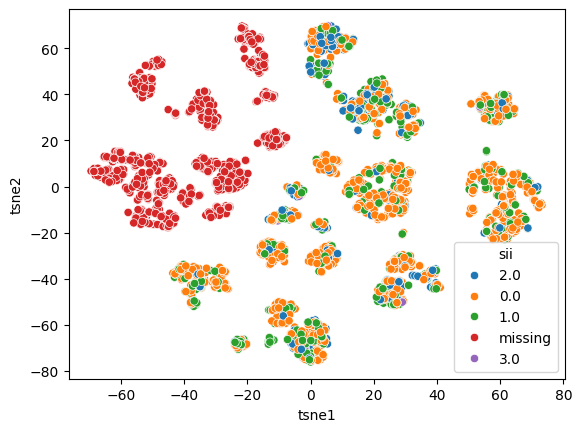

In [11]:
sns.scatterplot(data=train_tsne, x='tsne1', y='tsne2', hue='sii')

# PCA

In [12]:
%%time
train_pca = PCA(n_components=2).fit_transform(X)
train_pca = pd.DataFrame(train_pca, columns=['pca1', 'pca2'])
train_pca['sii'] = y.fillna('missing')
train_pca

CPU times: user 55 ms, sys: 3.17 ms, total: 58.2 ms
Wall time: 9.52 ms


,pca1,pca2,sii
0,0.458963,0.163281,2.0
1,0.639606,0.100753,0.0
2,0.237363,-0.294381,0.0
3,0.712897,0.065608,1.0
4,-0.971392,0.144966,missing
...,...,...,...
3955,0.714050,0.240696,1.0
3956,-0.676314,0.519847,missing
3957,0.689606,0.218821,1.0
3958,0.385542,-0.348945,0.0


<Axes: xlabel='pca1', ylabel='pca2'>

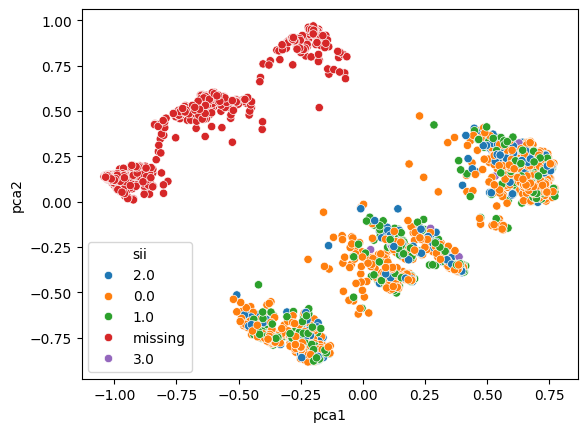

In [13]:
sns.scatterplot(data=train_pca, x='pca1', y='pca2', hue='sii')

# MiniBatchKMeans

In [14]:
%%time
train_pca = PCA(n_components=2).fit_transform(X)
train_pca = pd.DataFrame(train_pca, columns=['pca1', 'pca2'])

CPU times: user 131 ms, sys: 66.3 ms, total: 197 ms
Wall time: 28.1 ms


In [15]:
wcss = list()
silhouette = list()
for i in range(3, 10):
    cluster = MiniBatchKMeans(n_clusters=i, random_state=random_state)
    labels = cluster.fit_predict(train_pca)
    silhouette.append(silhouette_score(X, labels))
    wcss.append(cluster.inertia_)

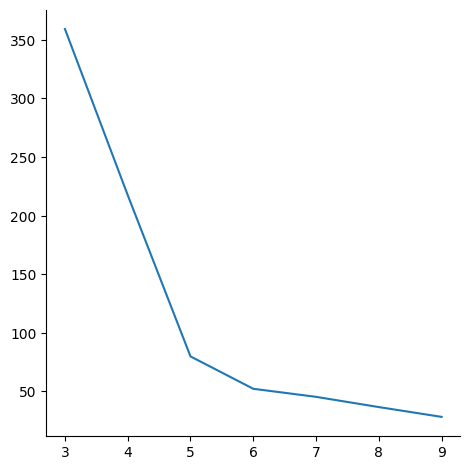

In [16]:
sns.relplot(x=range(3,10), y=wcss, kind='line')

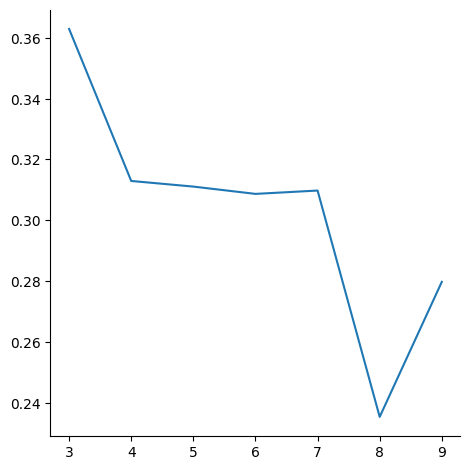

In [17]:
sns.relplot(x=range(3,10), y=silhouette, kind='line')